<a href="https://colab.research.google.com/github/tomonori-masui/graph-neural-networks/blob/main/gnn_pyg_implementations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Graph Neural Networks with PyG on Node Classification, Link Prediction, and Anomaly Detection

In this notebook, we will review PyG code implementations on major graph problems including node classification, link prediction, and anomaly detection.

In [ ]:
%%capture
import torch
version = torch.__version__
i = version.find('+')
version = version[:i-1] + '0' + version[i:]
url = 'https://data.pyg.org/whl/torch-' + version + '.html'

!pip install torch-scatter -f $url
!pip install torch-sparse -f $url
!pip install torch-geometric
!pip install torch-cluster -f $url
!pip install pygod

In [ ]:
from torch_geometric.data import Data
from torch_geometric.utils import to_networkx
import torch_geometric.transforms as T

import matplotlib.pyplot as plt
import networkx as nx
import random
import numpy as np
from collections import Counter

In [ ]:
def make_deterministic(random_seed = 123):
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(random_seed)

make_deterministic()

# 1. Loading Data
We are using [Cora dataset](https://paperswithcode.com/dataset/cora) for the following GCN implementations. The Cora dataset is a paper citation network data that consists of 2,708 scientific publications. Each node in the graph represents each publication and a pair of nodes is connected with an edge if one paper cites the other.

Through this notebook, we are using [PyG (Pytorch Geometric)](https://www.pyg.org/) to implement GCN which is one of the popular GNN libraries. The Cora dataset can also be loaded using PyG module.

In [ ]:
%%capture

from torch_geometric.datasets import Planetoid

dataset = Planetoid(root='/tmp/Cora', name='Cora')

In [ ]:
def show_dataset_stats(dataset):
    print(f"Number of graphs: {len(dataset)}")
    print(f"Number of node classes: {dataset.num_classes}")
    print(f"Number of node features: {dataset.num_node_features}")

show_dataset_stats(dataset)

Number of graphs: 1
Number of node classes: 7
Number of node features: 1433


In [ ]:
def show_graph_stats(graph):
    print(f"Number of nodes: {graph.x.shape[0]}")
    print(f"Number of node features: {graph.x.shape[1]}")
    print(f"Number of edges: {graph.edge_index.shape[1]}")

graph = dataset[0]
show_graph_stats(graph)

Number of nodes: 2708
Number of node features: 1433
Number of edges: 10556


The node features and the edge information look like below. The node features are 1433 word vectors indicating the absence (0) or the presence (1) of the words in each publication. The edges are represented in adjacency lists.

In [ ]:
graph.x

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [ ]:
graph.edge_index.T

tensor([[   0,  633],
        [   0, 1862],
        [   0, 2582],
        ...,
        [2707,  598],
        [2707, 1473],
        [2707, 2706]])

Each node has one of seven classes which is going to be our model target/label.

In [ ]:
"""
Class Definition
0: Theory
1: Reinforcement_Learning
2: Genetic_Algorithms
3: Neural_Networks
4: Probabilistic_Methods
5: Case_Based
6: Rule_Learning
"""

print("Class Distribution:")
sorted(Counter(graph.y.tolist()).items())

Class Distribution:


[(0, 351), (1, 217), (2, 418), (3, 818), (4, 426), (5, 298), (6, 180)]

## Visualizing Graph
The graph data can be visualized using [NetworkX](https://networkx.org/) library. The node colors represent the node classes.

In [ ]:
def convert_to_networkx(graph, n_sample=None):

    g = to_networkx(graph, node_attrs=["x"])
    y = graph.y.numpy()

    if n_sample is not None:
        sampled_nodes = random.sample(g.nodes, n_sample)
        g = g.subgraph(sampled_nodes)
        y = y[sampled_nodes]

    return g, y


def plot_graph(g, y):

    plt.figure(figsize=(9, 7))
    nx.draw_spring(g, node_size=30, arrows=False, node_color=y)
    plt.show() 

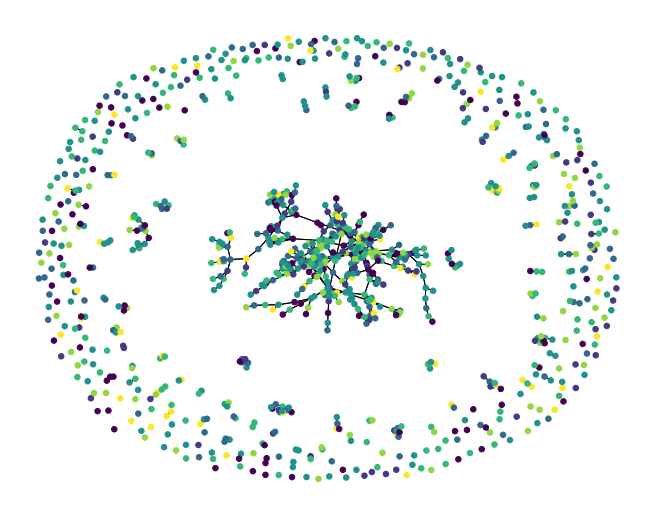

In [ ]:
g, y = convert_to_networkx(graph, n_sample=1000)
plot_graph(g, y)

# 2. Node Classification

For the node classification problem, we are splitting the nodes into train, valid, and test using the `RandomNodeSplit` module from PyG (we are replacing the original split masks in the data as it has a too small train set).

In [ ]:
def split_nodes(graph, val_pct = 0.1, test_pct = 0.2):
    split = T.RandomNodeSplit(num_val=val_pct, num_test=test_pct)
    return split(graph) # masks are written into graph object

grap = split_nodes(graph)  # resetting data split
print(
    f"train: {int(graph.train_mask.sum())}, ",
    f"val: {int(graph.val_mask.sum())}, ",
    f"test: {int(graph.test_mask.sum())}",
)

train: 1895, val: 271, test: 542


Please note the data splits are written into `mask` attributes in the graph object instead of splitting the graph itself. Those masks are only used for training loss calculation and model evaluation, and graph convolutions use entire graph data.

## 2-1. Baseline MLP model
Before we build GCN, we are training MLP (multi-layer perceptron, i.e. feed-forward neural nets) only using node features to set a baseline performance. The model ignores the node connections (or the graph structure) and tries to classify the node labels only using the word vectors. The model class looks like below. It has two hidden layers (`Linear`) with ReLU activations followed by an output layer.

In [ ]:
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
        nn.Linear(dataset.num_node_features, 64),
        nn.ReLU(),
        nn.Linear(64, 32),
        nn.ReLU(),
        nn.Linear(32, dataset.num_classes)
        )

    def forward(self, data):
        x = data.x  # only using node features (x)
        output = self.layers(x)
        return output

We are defining training and evaluation functions with a normal Pytorch train/eval setup.

In [ ]:
def train_node_classifier(model, graph, optimizer, criterion, n_epochs=200):

    for epoch in range(1, n_epochs + 1):
        model.train()
        optimizer.zero_grad()
        out = model(graph)
        loss = criterion(out[graph.train_mask], graph.y[graph.train_mask])
        loss.backward()
        optimizer.step()

        pred = out.argmax(dim=1)
        acc = eval_node_classifier(model, graph, graph.val_mask)

        if epoch % 10 == 0:
            print(f'Epoch: {epoch:03d}, Train Loss: {loss:.3f}, Val Acc: {acc:.3f}')

    return model


def eval_node_classifier(model, graph, mask):

    model.eval()
    pred = model(graph).argmax(dim=1)
    correct = (pred[mask] == graph.y[mask]).sum()
    acc = int(correct) / int(mask.sum())

    return acc

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
graph = graph.to(device)
mlp = MLP().to(device)
optimizer_mlp = torch.optim.Adam(mlp.parameters(), lr=0.01, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()

mlp = train_node_classifier(mlp, graph, optimizer_mlp, criterion, n_epochs=150)

Epoch: 010, Train Loss: 0.770, Val Acc: 0.694
Epoch: 020, Train Loss: 0.089, Val Acc: 0.727
Epoch: 030, Train Loss: 0.018, Val Acc: 0.716
Epoch: 040, Train Loss: 0.012, Val Acc: 0.720
Epoch: 050, Train Loss: 0.015, Val Acc: 0.753
Epoch: 060, Train Loss: 0.013, Val Acc: 0.745
Epoch: 070, Train Loss: 0.011, Val Acc: 0.749
Epoch: 080, Train Loss: 0.010, Val Acc: 0.734
Epoch: 090, Train Loss: 0.009, Val Acc: 0.731
Epoch: 100, Train Loss: 0.009, Val Acc: 0.734
Epoch: 110, Train Loss: 0.008, Val Acc: 0.742
Epoch: 120, Train Loss: 0.008, Val Acc: 0.742
Epoch: 130, Train Loss: 0.008, Val Acc: 0.734
Epoch: 140, Train Loss: 0.007, Val Acc: 0.731
Epoch: 150, Train Loss: 0.007, Val Acc: 0.723


In [ ]:
test_acc = eval_node_classifier(mlp, graph, graph.test_mask)
print(f'Test Acc: {test_acc:.3f}')

Test Acc: 0.732


## 2-2. GCN
Next, we are training GCN and comparing its performance to MLP. We are using a very simple model having two graph convolution layers and ReLU activation between them. This setup is the same as [the original paper](https://arxiv.org/pdf/1609.02907.pdf) (equation 9).

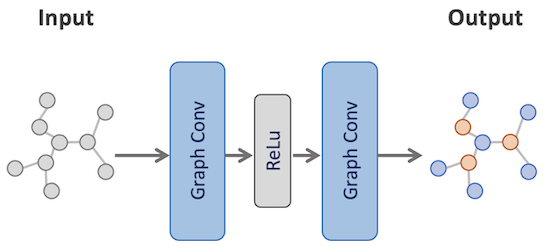

In [ ]:
from torch_geometric.nn import GCNConv
import torch.nn.functional as F

class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(dataset.num_node_features, 16)
        self.conv2 = GCNConv(16, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        output = self.conv2(x, edge_index)

        return output

In [ ]:
gcn = GCN().to(device)
optimizer_gcn = torch.optim.Adam(gcn.parameters(), lr=0.01, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()

gcn = train_node_classifier(gcn, graph, optimizer_gcn, criterion)

Epoch: 010, Train Loss: 1.017, Val Acc: 0.790
Epoch: 020, Train Loss: 0.411, Val Acc: 0.889
Epoch: 030, Train Loss: 0.240, Val Acc: 0.897
Epoch: 040, Train Loss: 0.178, Val Acc: 0.900
Epoch: 050, Train Loss: 0.149, Val Acc: 0.889
Epoch: 060, Train Loss: 0.135, Val Acc: 0.893
Epoch: 070, Train Loss: 0.126, Val Acc: 0.886
Epoch: 080, Train Loss: 0.117, Val Acc: 0.886
Epoch: 090, Train Loss: 0.110, Val Acc: 0.886
Epoch: 100, Train Loss: 0.103, Val Acc: 0.886
Epoch: 110, Train Loss: 0.097, Val Acc: 0.882
Epoch: 120, Train Loss: 0.092, Val Acc: 0.882
Epoch: 130, Train Loss: 0.088, Val Acc: 0.878
Epoch: 140, Train Loss: 0.085, Val Acc: 0.875
Epoch: 150, Train Loss: 0.081, Val Acc: 0.875
Epoch: 160, Train Loss: 0.079, Val Acc: 0.875
Epoch: 170, Train Loss: 0.076, Val Acc: 0.878
Epoch: 180, Train Loss: 0.074, Val Acc: 0.878
Epoch: 190, Train Loss: 0.072, Val Acc: 0.878
Epoch: 200, Train Loss: 0.070, Val Acc: 0.878


In [ ]:
test_acc = eval_node_classifier(gcn, graph, graph.test_mask)
print(f'Test Acc: {test_acc:.3f}')

Test Acc: 0.880


We achieved around 15% accuracy improvement from MLP.

### Visualizing classification result

yellow node: correct 
purple node: wrong


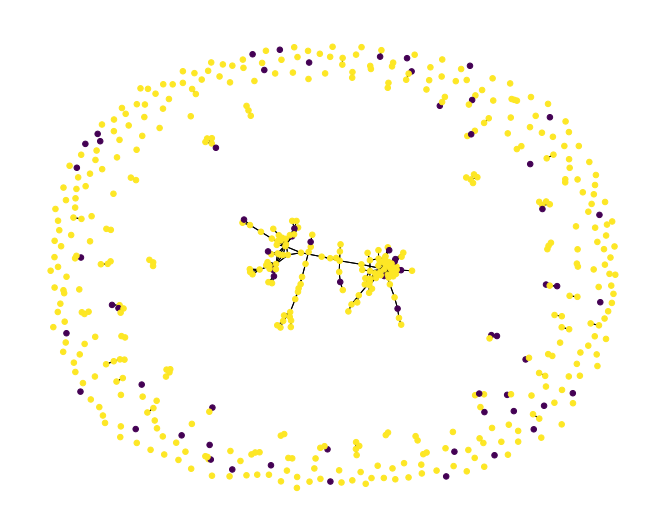

In [ ]:
def visualize_classification_result(model, graph):

    model.eval()
    pred = model(graph).argmax(dim=1)
    corrects = (pred[graph.test_mask] == graph.y[graph.test_mask]).numpy().astype(int)
    test_index = np.arange(len(graph.x))[graph.test_mask.numpy()]
    g, y = convert_to_networkx(graph)
    g_test = g.subgraph(test_index)

    print("yellow node: correct \npurple node: wrong")
    plot_graph(g_test, corrects)

visualize_classification_result(gcn, graph)

# 3. Link prediction
For the link prediction tasks, we first want to randomly split links/edges into train, valid, and test data. We can use the `RandomLinkSplit` module from PyG for that.

In [ ]:
def split_links(graph, val_pct=0.05, test_pct=0.1):

    split = T.RandomLinkSplit(
        num_val=val_pct,
        num_test=test_pct,
        is_undirected=True,
        add_negative_train_samples=False,
    )
    train_data, val_data, test_data = split(graph)

    return train_data, val_data, test_data


train_data, val_data, test_data = split_links(graph)

Link prediction is trickier than node classification as we need some tweaks to make predictions on edges using node embeddings. The prediction steps are described below:

1.   An encoder creates node embeddings by processing the graph with two 
convolution layers.
2.   We randomly add negative links to the original graph. This makes the model task a binary classification with the positive links from the original edges and the negative links from the added edges.
3.   A decoder makes link predictions (i.e. binary classifications) on all the edges including the negative links using node embeddings. It calculates a dot product of the node embeddings from pair of nodes on each edge. Then, it aggregates the values across the embedding dimension and creates a single value on every edge that represents the probability of edge existence.



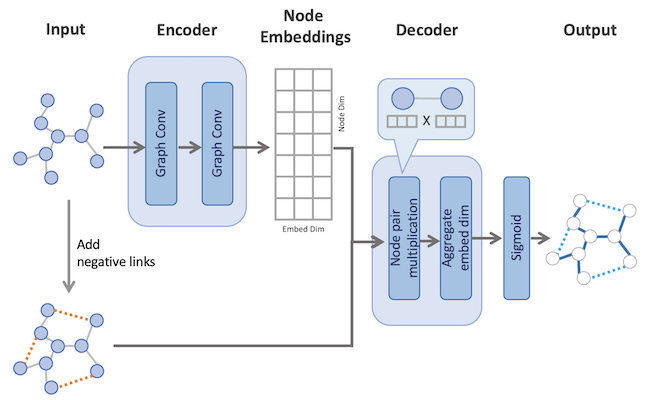

This setup is from [the original link prediction implementation in Variational Graph Auto-Encoders](https://github.com/tkipf/gae). The code looks like something below. This is adapted from [the code example in PyG repo](https://github.com/pyg-team/pytorch_geometric/blob/master/examples/link_pred.py) and modified based on the Graph Auto-Encoders implementation.

In [ ]:
class Net(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)

    def decode(self, z, edge_label_index):
        return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(
            dim=-1
        )  # product of a pair of nodes on each edge

    def decode_all(self, z):
        logit = z @ z.t()
        prob = torch.sigmoid(logit)
        return (prob > 0.5).nonzero(as_tuple=False).t()

In [ ]:
from sklearn.metrics import roc_auc_score
from torch_geometric.utils import negative_sampling


def train_link_predictor(
    model, train_data, val_data, optimizer, criterion, n_epochs=100
):

    # sampling valid negatives one time outside the loop
    val_edge_label_index, val_edge_label = add_negative_sample(val_data)

    for epoch in range(1, n_epochs + 1):

        model.train()
        optimizer.zero_grad()
        z = model.encode(train_data.x, train_data.edge_index)

        # sampling training negatives for every training epoch
        edge_label_index, edge_label = add_negative_sample(train_data)

        out = model.decode(z, edge_label_index).view(-1)
        loss = criterion(out, edge_label)
        loss.backward()
        optimizer.step()

        val_auc = eval_link_predictor(
            model, train_data, val_edge_label_index, val_edge_label
        )

        if epoch % 10 == 0:
            print(f"Epoch: {epoch:03d}, Train Loss: {loss:.3f}, Val AUC: {val_auc:.3f}")

    return model


@torch.no_grad()
def eval_link_predictor(model, train_data, test_edge_label_index, test_edge_label):

    model.eval()
    z = model.encode(
        train_data.x, train_data.edge_index
    )  # embeddings are created from train_data
    out = model.decode(z, test_edge_label_index).view(-1).sigmoid()

    return roc_auc_score(test_edge_label.cpu().numpy(), out.cpu().numpy())


def add_negative_sample(data):

    neg_edge_index = negative_sampling(
        edge_index=graph.edge_index,
        num_nodes=graph.num_nodes,
        num_neg_samples=data.edge_label_index.size(1),
        method="sparse",
    )

    edge_label_index = torch.cat([data.edge_label_index, neg_edge_index], dim=-1,)
    edge_label = torch.cat(
        [data.edge_label, data.edge_label.new_zeros(neg_edge_index.size(1))], dim=0
    )

    return edge_label_index, edge_label

Please note that when we evaluate the model (`eval_link_predictor`) the encoder uses `train_data` to create the node embeddings in order to avoid any target leaks while the decoder uses test edges.

In [ ]:
model = Net(dataset.num_features, 128, 64).to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)
criterion = torch.nn.BCEWithLogitsLoss()

model = train_link_predictor(model, train_data, val_data, optimizer, criterion)

Epoch: 010, Train Loss: 0.659, Val AUC: 0.731
Epoch: 020, Train Loss: 0.556, Val AUC: 0.841
Epoch: 030, Train Loss: 0.477, Val AUC: 0.876
Epoch: 040, Train Loss: 0.457, Val AUC: 0.881
Epoch: 050, Train Loss: 0.444, Val AUC: 0.885
Epoch: 060, Train Loss: 0.426, Val AUC: 0.886
Epoch: 070, Train Loss: 0.426, Val AUC: 0.894
Epoch: 080, Train Loss: 0.420, Val AUC: 0.896
Epoch: 090, Train Loss: 0.411, Val AUC: 0.893
Epoch: 100, Train Loss: 0.407, Val AUC: 0.898


In [ ]:
test_auc = eval_link_predictor(
    model, train_data, test_data.edge_label_index, test_data.edge_label
)
print(f"Test: {test_auc:.3f}")

Test: 0.924


# 4. Anomaly Detection

We are again using Cora dataset for the anomaly detection task, but it is slightly different from the previous one: the one with outliers being synthetically injected. The dataset has two different types of outliers (the outlier definition is from [this paper](https://arxiv.org/pdf/2206.10071.pdf)):

*   **Structural Outlier**: 
Densely connected nodes in contrast to sparsely connected regular nodes
*   **Contextual Outlier**: 
Nodes whose attributes are significantly different from their neighboring nodes


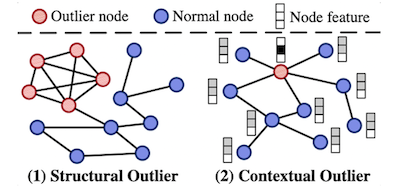

Node Outlier Types (Source: [https://arxiv.org/pdf/2206.10071.pdf](https://arxiv.org/pdf/2206.10071.pdf))

For this anomaly detection task, we are using [PyGOD library](https://docs.pygod.org/en/latest/index.html) which is a graph outlier detection library built on top of PyG. We can load the outlier-injected Cora dataset via the PyGOD module.

In [ ]:
from pygod.utils import load_data

graph = load_data('inj_cora').to(device)
show_graph_stats(graph)

Number of nodes: 2708
Number of node features: 1433
Number of edges: 11060


### Distribution of inlier/outlier types

In [ ]:
"""
0: inlier
1: contextual outlier only
2: structural outlier only
3: both contextual outlier and structural outlier
"""

Counter(graph.y.tolist())

Counter({0: 2570, 1: 68, 2: 68, 3: 2})

If you are interested in how these outliers are injected, you can look at [the PyGOD documentation on the outlier generator modules](https://docs.pygod.org/en/dev/pygod.generator.html) which explains the operation details. Please note that the labels `y` will only be used for model evaluation and not used for training labels as we are training an unsupervised model.

### Visualizing sampled graph

purple: inlier 
green: contextual outlier 
yellow: structural outlier


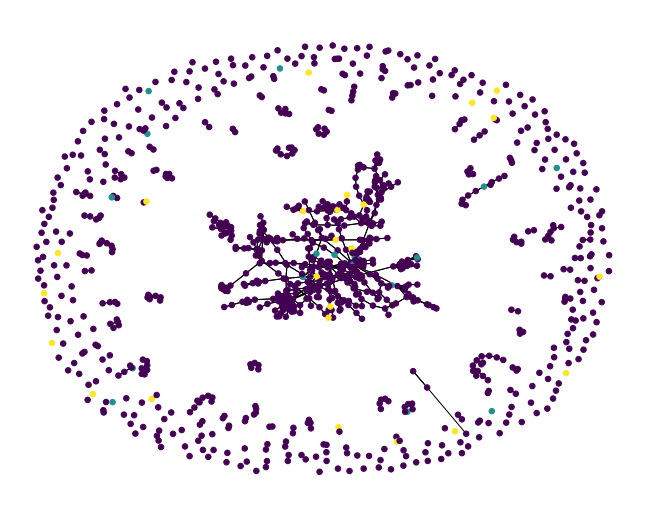

In [ ]:
g, y = convert_to_networkx(graph, n_sample=1000)

print("purple: inlier \ngreen: contextual outlier \nyellow: structural outlier")
plot_graph(g, y)

### Model Training and Evaluation

To detect those outliers, we are training `DOMINANT` (Deep Anomaly Detection on Attributed Networks) model from [this paper](https://www.public.asu.edu/~kding9/pdf/SDM2019_Deep.pdf). It is an auto-encoder network with graph convolution layers and its reconstruction errors are going to be the node anomaly scores. The model follows the steps below to make predictions.


1.   ***The attributed network encoder*** processes the input graph with three graph convolution layers that create node embeddings.
2.   ***The structure reconstruction decoder*** reconstructs the original graph edges (i.e. adjacency matrix) using the learned node embeddings. It calculates a dot product of node embeddings from every possible pair of nodes that creates a probability score on each node pair indicating edge existence.
3.   ***The attribute reconstruction decoder*** reconstructs the original node attributes using the obtained node embeddings. It has a graph convolution layer to predict the attribute values.
4.    In the last step, the reconstruction errors from the above two decoders are combined by weighted average on every node and the combined errors are going to be the final errors/losses. These final errors are also the abnormality scores of the nodes.

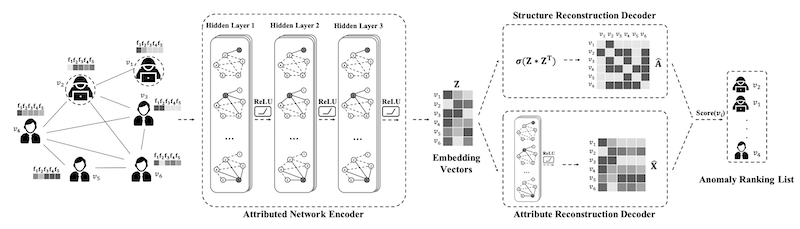

DOMINANT Model Architecture (Source: [Deep Anomaly Detection on Attributed Networks](https://www.public.asu.edu/~kding9/pdf/SDM2019_Deep.pdf))



The `DOMINANT` model can be easily implemented with PyGOD as you can see below.

In [ ]:
from pygod.models import DOMINANT
from sklearn.metrics import roc_auc_score, average_precision_score

def train_anomaly_detector(model, graph):
    return model.fit(graph)

def eval_anomaly_detector(model, graph):

    outlier_scores = model.decision_function(graph)
    auc = roc_auc_score(graph.y.numpy(), outlier_scores)
    ap = average_precision_score(graph.y.numpy(), outlier_scores)
    print(f'AUC Score: {auc:.3f}')
    print(f'AP Score: {ap:.3f}')

In [ ]:
graph.y = graph.y.bool()
model = DOMINANT()
model = train_anomaly_detector(model, graph)
eval_anomaly_detector(model, graph)

/usr/local/lib/python3.7/dist-packages/pygod/utils/utility.py:52: UserWarning: The cuda is not available. Set to cpu.
  warnings.warn('The cuda is not available. Set to cpu.')


AUC Score: 0.841
AP Score: 0.208


The AUC from this model is 84.1%, whereas its average precision is 20.8%. This difference is most likely due to the target imbalance. As this is an unsupervised model, we might not be able to expect very high model performance, but you can see in [the original paper](https://www.public.asu.edu/~kding9/pdf/SDM2019_Deep.pdf) that it still outperforms any other popular anomaly detection algorithms.